In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.dummy import DummyClassifier
import warnings

In [71]:
warnings.filterwarnings(action="ignore",category=FutureWarning)
df = pd.read_csv("data/combined_data.csv", low_memory=False)

features = ["occupation_le", "industry_le", "persinc_group_median", "employment_type_le", "homesubregion_ASGS_le", "agegroup_le"
]

target = "wfh_freq_le"

for feature in features + [target]:
    df[feature] = pd.to_numeric(df[feature], errors="coerce")

x = df[features]
y = df[target]

In [72]:
pipeline = Pipeline([("scaler", StandardScaler()),("knn", KNeighborsClassifier())])
grid ={"knn__n_neighbors": range(1, 21)}

gridSearch = GridSearchCV(
    estimator=pipeline,
    param_grid=grid,
    cv=10,
    scoring="accuracy"
)

gridSearch.fit(x,y)
results = pd.DataFrame(gridSearch.cv_results_)
results["k_value"] = results["param_knn__n_neighbors"]
results = results[["k_value", "mean_test_score", "std_test_score", "rank_test_score"]]
results.columns = ["k_value", "mean_accuracy", "std_accuracy", "rank"]
print(results.to_string(index=False))

 k_value  mean_accuracy  std_accuracy  rank
       1       0.588635      0.027615    19
       2       0.586570      0.023726    20
       3       0.631288      0.028324    18
       4       0.634033      0.015604    17
       5       0.653067      0.021519    16
       6       0.654901      0.029930    15
       7       0.669119      0.026290    13
       8       0.666596      0.025624    14
       9       0.673707      0.019446    12
      10       0.675312      0.025691     9
      11       0.674856      0.029217    11
      12       0.675084      0.023845    10
      13       0.678750      0.021564     8
      14       0.679208      0.021934     7
      15       0.681730      0.021254     6
      16       0.683337      0.019087     5
      17       0.687693      0.017331     3
      18       0.684481      0.016531     4
      19       0.692278      0.016183     1
      20       0.689525      0.013637     2


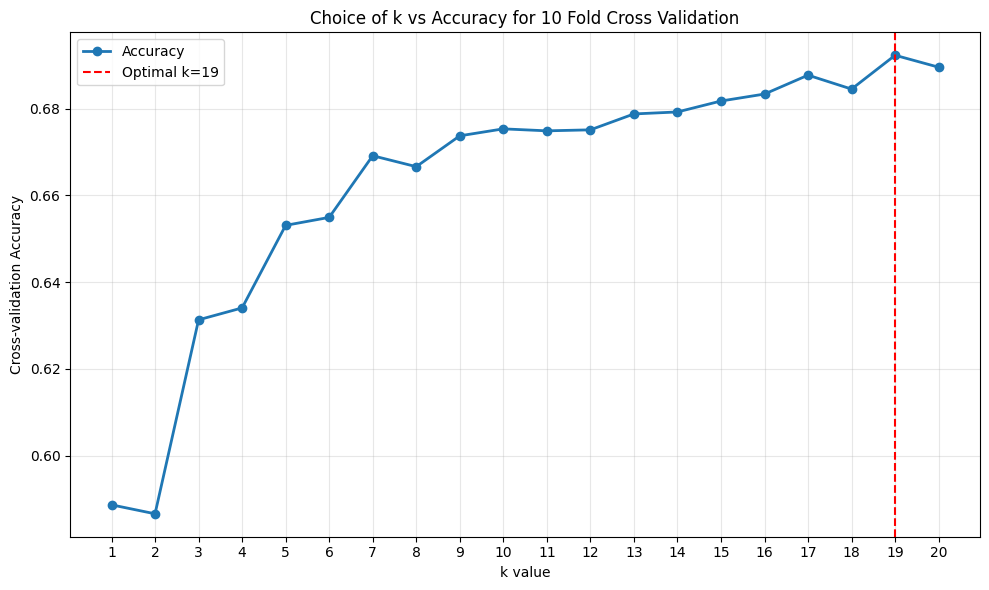

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(
    results["k_value"],
    results["mean_accuracy"],
    marker="o",
    linewidth=2,
    markersize=6,
    label="Accuracy"
)
plt.axvline(
    x=gridSearch.best_params_["knn__n_neighbors"],
    color="r",
    linestyle="--",
    label=f"Optimal k={gridSearch.best_params_["knn__n_neighbors"]}"
)
plt.xlabel("k value")
plt.xticks(range(1, 21))
plt.ylabel("Cross-validation Accuracy")
plt.title("Choice of k vs Accuracy for 10 Fold Cross Validation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("images/knn_cross_validation.png", dpi=300)
plt.show()
plt.close()

In [74]:
best_row = results.loc[results["mean_accuracy"].idxmax()]
k = int(best_row["k_value"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.25, random_state=1, stratify=y)
print("Training Dataset Size:", xTrain.shape[0])
print("Testing Dataset Size:", xTest.shape[0])

scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(xTrain, yTrain)
yPred = knn.predict(xTest)

accuracy = accuracy_score(yTest, yPred)
precision = precision_score(yTest, yPred, average="weighted")
recall = recall_score(yTest, yPred, average="weighted")
f1 = f1_score(yTest, yPred, average="weighted")
labels = ["Never", "Occasional", "Frequent"]

print(f"\nKNN Model Performance (k={k})")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nActual vs Predicted Proportions")
actualCounts = yTest.value_counts(normalize=True).sort_index()
predictedCounts = pd.Series(yPred).value_counts(normalize=True).sort_index()
for i, label in enumerate(labels):
    actual = actualCounts.get(i, 0) * 100
    predicted = predictedCounts.get(i, 0) * 100
    print(f"{label}: Actual={actual:.2f}, Predicted={predicted:.2f}")

Training Dataset Size: 3270
Testing Dataset Size: 1091

KNN Model Performance (k=19)
Accuracy: 0.6783
Precision: 0.6315
Recall: 0.6783
F1 Score: 0.6390

Actual vs Predicted Proportions
Never: Actual=21.08, Predicted=18.06
Occasional: Actual=65.17, Predicted=78.28
Frequent: Actual=13.75, Predicted=3.67


<Figure size 800x600 with 0 Axes>

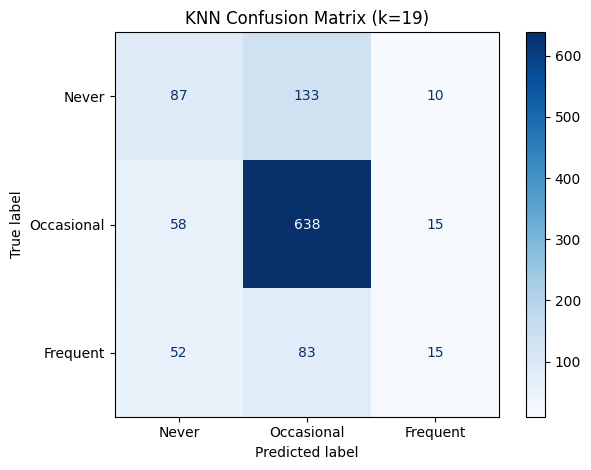

In [75]:
matrix = confusion_matrix(yTest, yPred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"KNN Confusion Matrix (k={k})")
plt.tight_layout()
plt.savefig("images/knn_confusion_matrix.png", dpi=300)
plt.show()
plt.close()